In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vnstock import Quote
from vnstock import Finance
from scipy import stats
import time
from typing import Literal
from scipy.interpolate import interp1d
from pyvinecopulib import Bicop, FitControlsBicop
from scipy.optimize import minimize

<h1>I. Thu thap du lieu<h1>

<h2>1. Xac dinh cong ty can de tam<h2>
<h3>Phan nay khong can chay lai nua<h3>

In [ ]:
#Tim ma chung khoan cua cac cong ty
symbol = pd.read_csv('Du lieu.csv')
symbol.columns = symbol.iloc[0]
symbol = symbol.iloc[1::]
interest_industry = list(symbol['Lĩnh vực'].unique())
interest_industry.pop(1)
symbol = symbol[symbol['Lĩnh vực'].isin(interest_industry)]
symbol_name = list(symbol['Công ty'])

In [ ]:
#Phan chia so lan lay du lieu
STT_list = [0,55,110,156]
name_bins = {}
for i in range(len(STT_list)):
    if STT_list[i] == 0:
        continue
    else:
        name_bins[STT_list[i]] = symbol_name[STT_list[i-1]:STT_list[i]]
history_price = pd.DataFrame()

In [ ]:
#Thu thap du lieu ve gia
#Khong can chay o du lieu nay
for i in name_bins[156]:
    pr = Quote(source='VCI',symbol=i)
    price_status = pr.history(start='2010-01-01',end='2025-01-01',interval='1M')
    price_status['time'] = pd.to_datetime(price_status['time'])
    price_status.set_index('time', inplace=True)
    history_price[i] = price_status['close']

<h2>2. Chon loc ra cac co phieu trong so 200 cp co gia tri von hoa lon nhat<h2>
<h3>Phan nay khong can chay lai nua<h3>

In [ ]:
#chia co phieu ra lam 2 thoi ky
history_price = pd.read_csv('price data.csv')
history_price['time'] = pd.to_datetime(history_price['time'])
history_price.set_index('time', inplace=True)
history_price = history_price[history_price.index.year>2015]
history_price.dropna(axis=1,inplace=True)
history_price.to_csv('compare_period1.csv')


<h2>3. Tai du lieu BCTC ve<h2>
<h3>Phan nay khong can chay lai nua<h3>

In [ ]:
#Cac co phieu can lay bao cao tai chinh
data = pd.read_csv('compare_period1.csv')
data['time'] = pd.to_datetime(data['time'])
data.set_index('time',inplace=True)
stock_of_interest = list(data.columns)

In [ ]:
#chia ra thanh cac muc nho hon de lay du lieu
count = 0
stock_trench = {}
number_stock_per_trench = 7
number_of_trench = int(round(len(stock_of_interest)/number_stock_per_trench,0)+1)
separate_support = [min(number_stock_per_trench*i, len(stock_of_interest)) for i in range(number_of_trench)]#cu chon  co phieu 1 danh sach
for i in range(1,len(separate_support)):
    stock_trench[separate_support[i]] = stock_of_interest[separate_support[i-1]:separate_support[i]]
financial_statement_data = pd.DataFrame()#phuc vu cho cell ke tiep
stock_trench

In [ ]:
char_cf = ['Năm', 'Kỳ','Khấu hao TSCĐ',
           'Mua sắm TSCĐ','Tiền thu được từ thanh lý tài sản cố định'  ]
char_is = ['Năm', 'Kỳ','Doanh thu thuần','Thu nhập tài chính','Thu nhập khác','LN trước thuế','Chi phí tiền lãi vay']
char_bs = ['Năm', 'Kỳ','TÀI SẢN NGẮN HẠN (đồng)','Tiền và tương đương tiền (đồng)', 'Giá trị thuần đầu tư ngắn hạn (đồng)','Nợ ngắn hạn (đồng)',
           'Vay và nợ thuê tài chính ngắn hạn (đồng)',
           'Vay và nợ thuê tài chính dài hạn (đồng)',
           'TỔNG CỘNG TÀI SẢN (đồng)','VỐN CHỦ SỞ HỮU (đồng)','LỢI ÍCH CỦA CỔ ĐÔNG THIỂU SỐ']
char_ratio = ['Năm', 'Kỳ','Số CP lưu hành (Triệu CP)']
sleep_time = 40
for t in list(stock_trench.keys())[-2::]:
    for i in stock_trench[t]:
        if i == "DPP":
            continue
        else:
            finance = Finance(source='VCI',symbol=i)
            #bao cao ket qua hoat dong kinh doanh
            income_state = finance.income_statement(lang='vi')
            for j in char_is:
                if j not in income_state.columns:
                    income_state[j]=0
            income_state = income_state[char_is]
            income_state = income_state[income_state['Năm']>2012]
            year = list(income_state['Năm'])
            quarter = list(income_state['Kỳ'])
            time1 = [f'{i}Q{j}' for i,j in zip(year,quarter)]
            time1 = pd.PeriodIndex(time1,freq='Q').to_timestamp(how='end').normalize()
            income_state['time'] = time1
            income_state.set_index('time',inplace=True)
            income_state.drop(['Năm','Kỳ'],axis=1, inplace=True)
            #bang can doi ke toan
            balance_sheet = finance.balance_sheet(lang='vi')
            for j in char_bs:
                if j not in balance_sheet.columns:
                    balance_sheet[j]=0
            balance_sheet = balance_sheet[char_bs]
            balance_sheet = balance_sheet[balance_sheet['Năm']>2012]
            balance_sheet['time'] = time1
            balance_sheet.drop(['Năm','Kỳ'],axis=1, inplace=True)
            balance_sheet.set_index('time', inplace=True)
            #bao cao luu chuyen tien te
            cashflow = finance.cash_flow(lang='vi')
            for j in char_cf:
                if j not in cashflow.columns:
                    cashflow[j] = 0
            cashflow = cashflow[char_cf]
            cashflow = cashflow[cashflow['Năm']>2012]
            cashflow['time'] = time1
            cashflow.set_index('time', inplace=True)
            cashflow.drop(['Năm','Kỳ'],axis=1, inplace=True)
            #so luong co phieu dang luu hanh
            outstanding_share = finance.ratio(lang='vi')
            outstanding_share = outstanding_share.droplevel(level=0,axis=1)
            for j in char_ratio:
                if j not in outstanding_share.columns:
                    outstanding_share[j] = 0
            outstanding_share = outstanding_share[char_ratio]
            outstanding_share = outstanding_share[outstanding_share['Năm']>2012]
            outstanding_share['time']=time1
            outstanding_share.set_index('time',inplace=True)
            outstanding_share.drop(['Năm','Kỳ'],axis=1, inplace=True)
            #sap nhap cac bao cao lai thanh 1 dataframe
            financial_statement_subdata = pd.concat([income_state,balance_sheet,cashflow,outstanding_share], axis=1)
            financial_statement_subdata['ticket'] = i
            #sap nhap cac cong ty lai thanh 1
            if len(financial_statement_data) == 0:
                financial_statement_data = financial_statement_subdata
            else:
                financial_statement_data = pd.concat([financial_statement_data,financial_statement_subdata],axis=0)
    time.sleep(sleep_time)


<h2>4. Xac nhan lai cac cong ty can de tam, dong thoi thu thap du lieu gia<h2>
<h3>Phan nay khong can chay lai nua<h3>

In [ ]:
#lay du lieu
financial_statement_data = pd.read_csv('financial_statements.csv')
financial_statement_data['time'] = pd.to_datetime(financial_statement_data['time'])
financial_statement_data.set_index(['ticket','time'], inplace=True)

In [ ]:
#Phan trench de lay du lieu
stock_of_interest = list(financial_statement_data.index.get_level_values(0).unique())
stock_trench = {}
number_stock_per_trench = 20
number_of_trench = int(round(len(stock_of_interest)/number_stock_per_trench,0)+1)
trench = [min(number_stock_per_trench*i,len(stock_of_interest)) for i in range(number_of_trench)]
l=0
for i in range(1,len(trench)):
    stock_trench[trench[i]] = stock_of_interest[trench[i-1]:trench[i]]
    l += len(stock_of_interest[trench[i-1]:trench[i]])



In [ ]:
input_data = pd.DataFrame()
compare_data = pd.DataFrame()
for t in stock_trench.keys():
    for i in stock_trench[t]:
        his = Quote(source='VCI', symbol=i)
        #du lieu dau vao
        input_subdata = his.history(start='2015-01-01',end='2026-01-01',interval='1M')
        input_subdata['time'] = pd.to_datetime(input_subdata['time'])
        input_subdata.set_index('time',inplace=True)
        input_subdata = input_subdata[['close']]
        input_subdata.columns = [i]
        #Du lieu so sanh
        compare_subdata = his.history(start='2020-01-01',end='2026-01-01',interval='1D')
        compare_subdata['time'] = pd.to_datetime(compare_subdata['time'])
        compare_subdata.set_index('time',inplace=True)
        compare_subdata = compare_subdata[['close']]
        compare_subdata.columns = [i]
        if len(input_data)==0:
            input_data = input_subdata
        else:
            input_data = pd.concat([input_data,input_subdata],axis=1)
        if len(compare_data)==0:
            compare_data = compare_subdata
        else:
            compare_data = pd.concat([compare_data,compare_subdata],axis=1)
    time.sleep(35)
    

In [ ]:
input_data = input_data.dropna(axis=0)
compare_data = compare_data[compare_data.index.year>2020]
input_data.to_csv('input_data.csv')
compare_data.to_csv('compare_data.csv')

In [ ]:
ticket_general_info = pd.read_csv('Du_lieu.csv')
col = ticket_general_info.iloc[0].to_list()
ticket_general_info.columns = col
ticket_general_info = ticket_general_info.drop(index=ticket_general_info.index[0])
ticket_general_info.set_index('Công ty',inplace=True)

In [ ]:
ticket_of_interest = pd.read_csv('compare_data.csv')
ticket_of_interest['time'] = pd.to_datetime(ticket_of_interest['time'])
ticket_of_interest.set_index('time',inplace=True)
info_of_interest_ticket = ticket_general_info.loc[ticket_of_interest.columns]
info_of_interest_ticket.to_csv('info_of_ticket.csv')

<h1>II. Thuat toan phan bo danh muc<h1>

<h2>1. Xay dung du lieu dau vao cho mo hinh<h2>

<h3>1.1. Bo chi tieu dau vao va cac thanh phan phu khac <h3>

In [3]:
#xu ly du lieu dau vao
raw_data = pd.read_csv('financial_statements.csv')
raw_data['time']= pd.to_datetime(raw_data['time'])
raw_data.set_index(['ticket','time'],inplace=True)
raw_data = raw_data.sort_index(level='time',ascending=True)
raw_data =raw_data[raw_data.index.get_level_values(level='time').year<2021] 


In [4]:
#Tinh cac chi tieu trung gian 
intermediary_data = raw_data['Doanh thu thuần']+raw_data['Thu nhập tài chính']+raw_data['Thu nhập khác']
intermediary_data = intermediary_data.to_frame(name='dttn')
## chi phí được ghi âm thay vì dương nên cần phải cận thận khi công trừ các chi tiêu này
intermediary_data['ebit'] = raw_data['LN trước thuế'] - raw_data['Chi phí tiền lãi vay']
intermediary_data['interest'] = - raw_data['Chi phí tiền lãi vay']
intermediary_data['dna'] = raw_data['Khấu hao TSCĐ']
intermediary_data['capex'] = -raw_data['Mua sắm TSCĐ'] - raw_data['Tiền thu được từ thanh lý tài sản cố định']
intermediary_data['wc'] = (raw_data['TÀI SẢN NGẮN HẠN (đồng)']-raw_data['Giá trị thuần đầu tư ngắn hạn (đồng)'] - raw_data[
    'Tiền và tương đương tiền (đồng)']) - (raw_data['Nợ ngắn hạn (đồng)']-raw_data['Vay và nợ thuê tài chính ngắn hạn (đồng)'])
intermediary_data['debt'] = raw_data['Vay và nợ thuê tài chính ngắn hạn (đồng)']+raw_data['Vay và nợ thuê tài chính dài hạn (đồng)']
intermediary_data['equity'] = raw_data['VỐN CHỦ SỞ HỮU (đồng)']
intermediary_data['value'] = intermediary_data['debt']+intermediary_data['equity']#day chinh la chi tieu V
intermediary_data['TA'] = raw_data['TỔNG CỘNG TÀI SẢN (đồng)']
#Tao dung cac mau du lieu dau tien, dữ liệu này là kỳ gần nhất đóng vai trò tính toán ra các dữ liệu trong tương lai ví dụ nhu DTTN
latest_time_of_raw_data = raw_data.groupby(level='ticket').last()
latest_time_of_intermediary_data =intermediary_data.groupby(level='ticket').last() 
ind = latest_time_of_raw_data.index
col = ['dttn','wc','minor_rate','out_share','cash','debt']
initial_data_set = np.full(shape=(len(ind),len(col)),fill_value=0)
initial_data_set = pd.DataFrame(initial_data_set,columns=col,index=ind)
initial_data_set['dttn'] = latest_time_of_intermediary_data['dttn']
initial_data_set['wc'] = latest_time_of_intermediary_data['wc']
initial_data_set['minor_rate'] = latest_time_of_raw_data['LỢI ÍCH CỦA CỔ ĐÔNG THIỂU SỐ']/latest_time_of_raw_data['VỐN CHỦ SỞ HỮU (đồng)']
initial_data_set['out_share'] = latest_time_of_raw_data['Số CP lưu hành (Triệu CP)']
initial_data_set['value'] = latest_time_of_intermediary_data['value']
initial_data_set['debt'] = latest_time_of_intermediary_data['debt']
initial_data_set['cash'] = latest_time_of_raw_data['Tiền và tương đương tiền (đồng)']

In [5]:
raw_data = pd.read_csv('financial_statements.csv')
raw_data['time']= pd.to_datetime(raw_data['time'])
raw_data.set_index(['ticket','time'],inplace=True)
raw_data = raw_data.sort_index(level='time',ascending=True)
raw_data =raw_data[raw_data.index.get_level_values(level='time')>=pd.to_datetime('2020-12-31')] 

In [6]:
#Du lieu cho ky so sanh
initial_data_set['out_share'] = raw_data['Số CP lưu hành (Triệu CP)'].groupby(level=0).last()
deterministic_complementary = pd.DataFrame(raw_data['LỢI ÍCH CỦA CỔ ĐÔNG THIỂU SỐ'
                                                    ]/raw_data['VỐN CHỦ SỞ HỮU (đồng)'],columns=['minor_rate'])
deterministic_complementary['net_debt'] = raw_data['Vay và nợ thuê tài chính ngắn hạn (đồng)'
                                                   ]+raw_data['Vay và nợ thuê tài chính dài hạn (đồng)'
                                                              ]- raw_data['Tiền và tương đương tiền (đồng)']
deterministic_complementary = deterministic_complementary.join(initial_data_set['out_share'],on='ticket')
deterministic_complementary['net_debt_per_share'] = deterministic_complementary['net_debt']/deterministic_complementary['out_share']
deterministic_complementary.drop(labels=['out_share','net_debt'],axis=1,inplace=True)

In [7]:
#Bo chi tieu can quan tam
input_ratio = np.log(intermediary_data['dttn']/intermediary_data['dttn'].groupby(level='ticket').shift())
input_ratio = input_ratio.to_frame(name='g_log')
input_ratio['omr'] = intermediary_data['ebit']/intermediary_data['dttn']
input_ratio['dpoc'] = intermediary_data['dna']/(intermediary_data['dttn']-intermediary_data['ebit'])
input_ratio['lrr'] = intermediary_data['dna']/intermediary_data['capex']
input_ratio['wct'] = intermediary_data['dttn']/intermediary_data['wc']
input_ratio['hskd'] = intermediary_data['dttn']/intermediary_data['TA']
input_ratio['ht'] = intermediary_data['equity']/intermediary_data['TA']
input_ratio['wod'] = intermediary_data['debt']/(intermediary_data['TA']-intermediary_data['equity']) 

invalid value encountered in log


<h2>2. Xay dung cau truc phu thuoc giua cac bien<h2>

<h3>2.1. Chuan hoa bo chi tieu<h3>

<h4>2.1.1. Cac ham lien quan<h4>

In [8]:
#Xay dung ham phan phoi dua tren gaussian kde
data_type = Literal['in_R','minus_infty_to_one','binary','zero_to_infty']
infinitesimal = 1e-9
quantity_for_intepld = 1000000
class kde_distribution:
    def __init__(self,data_set,type_of_data:data_type):
        self.type = type_of_data
        data = data_set.replace([np.inf,-np.inf],np.nan)
        data = data_set.dropna()
        if self.type == 'in_R':
            self.data = data
            self.range = np.linspace(-200,200,quantity_for_intepld)
        elif self.type == 'minus_infty_to_one':
            self.data = -np.log(1-data)
            self.range = np.linspace(-200,1-infinitesimal,quantity_for_intepld)
        elif self.type == 'binary':
            data += infinitesimal
            self.data = np.log(data/(1-data))
            self.range = np.linspace(0+infinitesimal,1-infinitesimal,quantity_for_intepld)
        elif self.type == 'zero_to_infty':
            self.data = np.log(data)
            self.range = np.linspace(0+infinitesimal,200,quantity_for_intepld)
        self.kde = stats.gaussian_kde(self.data)
        self._pdf = self.pdf(self.range)
        self.cdf_val = np.cumsum(self._pdf)
        self.cdf_val/= self.cdf_val[-1]
        self._cdf = interp1d(self.range,self.cdf_val,kind='linear',bounds_error=False,fill_value=(0,1))
        self._ppf = interp1d(self.cdf_val,self.range,kind='linear',bounds_error=False, fill_value="extrapolate")
    def pdf(self, x):
        if self.type == 'in_R':
           p = self.kde(x)
        elif self.type == 'minus_infty_to_one':
            p = self.kde(-np.log(1-x))/np.log(1-x) 
        elif self.type == 'binary':
            p = self.kde(np.log(x/(1-x)))/(x-x**2)
        elif self.type == 'zero_to_infty':
            p = self.kde(np.log(x))/x
        return p
    def cdf (self,x):
        return self._cdf(x)
    def ppf (self,u):
        return self._ppf(u)

<h4>2.1.2. Thuat toan normalize chi tieu bang CDF<h4>

In [9]:
#Phan nhom bo chi tieu
in_R = ['g_log','lrr','wct']
minus_infty_to_one = ['omr','dpoc']
binary = ['ht','wod']
zero_to_infty = ['hskd']
input_ratio = input_ratio.replace([-np.inf,np.inf],np.nan)
ticket = input_ratio.index.get_level_values(level=0).unique()
ratio = input_ratio.columns
standardised_input_ratio = pd.DataFrame()
#Chuan hoa du lieu
for i in ticket:
    data_set = input_ratio.xs(i,level=0)
    single_stock = pd.DataFrame()
    for j in ratio:
        n = len(data_set[j].dropna())+1
        if len(single_stock) == 0:
            single_stock = data_set[[j]].rank(method='average')/n
        else:
            mediate = data_set[[j]].rank(method='average')/n
            single_stock = pd.concat([single_stock,mediate],axis=1)
    single_stock['ticket'] = i
    if len(standardised_input_ratio)==0:
        standardised_input_ratio = single_stock
    else:
        standardised_input_ratio = pd.concat([standardised_input_ratio,single_stock],axis=0)
standardised_input_ratio.set_index('ticket',append=True,inplace=True)
standardised_input_ratio = standardised_input_ratio.reorder_levels(['ticket','time'],axis=0)
    

<h3>2.2. Xay dung thu tu phu thuoc<h3>

<h4>2.2.1. Su phu thuoc giua cac doanh nghiep voi nhau<h4>

In [10]:
#Ma tran MI cua g_log giua cac doanh nghiep voi nhau
standardised_g_log = standardised_input_ratio[['g_log']].unstack('ticket').droplevel(level=0,axis=1)
outter_correlation_matrix = standardised_g_log.corr(method='kendall')
""" ma trận xếp hạng hệ số tương quan sẽ được xếp giữa trên độ lớn của hệ số tương quan kendall tau(tức là trị tuyết đối)
    Xếp hạng được xếp theo dòng và phân theo thứ tự giảm dần tức là hệ số có tương quan cao nhất sẽ được xếp hạng 1"""
outter_rank_matrix = outter_correlation_matrix.abs().rank(axis=1,ascending=False,method='min')

In [11]:
outter_dependence_tree = []
stock = 'AAA'
init_stock = [stock]
ticket = list(outter_rank_matrix.columns)
ticket.remove(stock)
while len(ticket) != 0:
    mediate_term = []
    for i in init_stock:
        data = outter_correlation_matrix[i].loc[ticket].sort_values(ascending=True)
        most_correlated = data.iloc[0]
        if most_correlated==2:
            dependence_stock = list(data[data==most_correlated].index)
        else:
            dependence_stock = [data[data==most_correlated].index[0]]
        for j in dependence_stock:
            outter_dependence_tree.append(f'{i}-{j}')
            ticket.remove(j)
            mediate_term.append(j)
    init_stock = mediate_term

<h4>2.2.2. Su phu thuoc trong doanh nghiep<h4>

In [12]:
ticket = list(standardised_input_ratio.index.get_level_values(level='ticket').unique())
inner_dependence_tree = {}
init_ratio = 'g_log'
for i in ticket:
    sub_independence_tree = []
    data = standardised_input_ratio.xs(i, level='ticket')
    ratio = list(data.columns)
    init_set = [init_ratio]
    ratio.remove(init_ratio)
    corr_matrix = data.corr(method='kendall')
    rank_matrix = corr_matrix.abs().rank(axis=1,ascending=False,method='min')
    while len(ratio) != 0 :
        mediate_term = []
        for j in init_set:
            if len(ratio)==0:
                break
            rank_of_interest = rank_matrix[j].loc[ratio].sort_values(ascending=True)
            most_correlated = rank_of_interest.iloc[0]
            if most_correlated == 2:
                dependence_set = list(rank_of_interest[rank_of_interest==2].index)
            else:
                dependence_set = [rank_of_interest.index[0]]
            for t in dependence_set:
                sub_independence_tree.append(f'{j}-{t}')
                ratio.remove(t)
                mediate_term.append(t)
        init_set = mediate_term
    inner_dependence_tree[i] = sub_independence_tree

<h3>2.3. Xay dung cau truc phu thuoc<h3>

In [13]:
controls = FitControlsBicop(selection_criterion='aic')

In [14]:
def bootstrap(data:np.ndarray, sample_size:int, simulation_size:int):
    """Bootstrapping function

    Args:
        data (np.ndarray) shape=(n,d)
        sample_size (int)
        simulation_size (int): how many times bootstrapping
    
    Return:
    ------------
        data (np.ndarray) shape(simulation_size, sample_size, d)
    """
    n = len(data)-1 #vi tri diem cuoi cua data
    position = np.random.randint(0,n,size=(simulation_size,sample_size))
    return data[position]
def empirical_cdf (data:np.ndarray):
    """Empirical cdf used empirical data as the proxy for true cdf which is P(X <= x)

    Args:
        data (np.ndarray): shape = (n,d)
        x (np.ndarray): shape = (n,1,d)
        X (np.ndarray): shape = (1,n,d)
    
    Return
    -------
        A float number lies in range (0,1)^n \in R^n
        
    """
    x = data[:,None,:]
    X = data[None,:,:]
    return np.mean(np.all(X<=x,axis=2),axis=0)
class Cvm_test:
    def __init__(self,cop_func):
        self.copula = cop_func
    def CvM_statistic(self,data:np.ndarray):
        """Cramer - Von Mises statistic
            Formula:
            \sum_{i=1}^n{(C_n(u_i)-C_{\theta}(u_i))^2}
        Args:
            data (np.ndarray): 

        Returns:
            _type_: _description_
        """
        C_n = empirical_cdf(data)
        C_theta = self.copula.cdf(data)
        return np.sum((C_n-C_theta)**2)
    def pvalue(self,data:np.ndarray,number_of_simulation:int,sample_size:int):
        """Pvalue of Cramer - Von Mises statistic

        Args:
            data (np.ndarray): shape = (n,d)
            number_of_simulation (int): 
            sample_size (int): 

        Returns:
            a number lies in (0,1)
        """
        bootstrap_data = bootstrap(data,simulation_size=number_of_simulation,sample_size=sample_size)
        statistic = self.CvM_statistic(data)
        CvM_stats_vector = []
        CvM_stats_vector = np.array([self.CvM_statistic(i) for i in bootstrap_data])
        return np.mean(CvM_stats_vector>=statistic)    

invalid escape sequence '\i'
invalid escape sequence '\s'
invalid escape sequence '\i'
invalid escape sequence '\s'
invalid escape sequence '\i'
invalid escape sequence '\s'


<h4>2.3.1. Su phu thuoc giua cac doanh nghiep voi nhau<h4>

In [15]:
outter_dependence_structure = {}
number_of_bootsrapping = 10000
ticker = list(standardised_input_ratio.index.get_level_values(level='ticket').unique())
CvM_pvalue_matrix = np.full(shape=(len(ticker),len(ticker)),fill_value=np.nan)
CvM_pvalue_matrix = pd.DataFrame(CvM_pvalue_matrix,index=ticker,columns=ticker)
for pair in outter_dependence_tree:
    pair_name = pair.split('-')
    data = standardised_g_log[pair_name].dropna()
    uv = data.to_numpy()
    cop_func = Bicop()
    cop_func.select(uv,controls=controls)
    # test = Cvm_test(cop_func)
    # pvalue = test.pvalue(uv, number_of_simulation=number_of_bootsrapping,sample_size=uv.shape[0])
    # CvM_pvalue_matrix.loc[pair_name[0],pair_name[1]] = pvalue
    outter_dependence_structure[pair] = cop_func

<h4>2.3.2. Su phu thuoc ben trong doanh nghiep(giua cac chi tieu voi nhau)<h4>

In [16]:
ticker = list(standardised_input_ratio.index.get_level_values(level='ticket').unique())
list_of_ratio = standardised_input_ratio.columns.to_list()
inner_cvm_pvalue = pd.DataFrame()
number_of_bootsrapping = 10000
inner_dependence_structure = {}
n = len(list_of_ratio)
for i in ticker:
    sub_pvalue_matrix = np.full(shape=(n,n),fill_value=np.nan)
    sub_pvalue_matrix = pd.DataFrame(sub_pvalue_matrix,index=list_of_ratio,columns=list_of_ratio)
    sub_inner_dependence_tree = inner_dependence_tree[i]
    data = standardised_input_ratio.xs(i,level='ticket')
    single_stock = {}
    for pair in sub_independence_tree:
        ratio_pair = pair.split('-')
        uv = data[ratio_pair].dropna().to_numpy()
        cop_func = Bicop()
        cop_func.select(uv,controls=controls)
        single_stock[pair] = cop_func
        # test = Cvm_test(cop_func)
        # pvalue = test.pvalue(uv,number_of_simulation=number_of_bootsrapping,sample_size=uv.shape[0])
        # sub_pvalue_matrix.loc[ratio_pair[0],ratio_pair[1]] = pvalue
    # sub_pvalue_matrix['ticket'] = i
    inner_dependence_structure[i] = single_stock
#     if len(inner_cvm_pvalue)==0:
#         inner_cvm_pvalue = sub_pvalue_matrix
#     else:
#         inner_cvm_pvalue = pd.concat([inner_cvm_pvalue,sub_pvalue_matrix],axis=0)
# inner_cvm_pvalue.index.names = ['ratio']
# inner_cvm_pvalue.set_index('ticket',append=True,inplace=True)
# inner_cvm_pvalue = inner_cvm_pvalue.reorder_levels(['ticket','ratio'])

<h2>3. Xay dung phan phoi xac suat cho ky so sanh<h2>

<h3>3.1. Xay dung cac ham can su dung<h3>

In [264]:
in_R = ['g_log','lrr','wct']
minus_infty_to_one = ['omr']
binary = ['ht','wod','dpoc']
zero_to_infty = ['hskd']
data_type = Literal['in_R','minus_infty_to_one','binary','zero_to_infty']
def objective_function_theta(parameter_vector:np.ndarray, q_vector:np.ndarray, projection_vector:np.ndarray, type: data_type,infinitesimal:float  ):
    """Objective function is the function that have to be optimized to estimate parameter for projected distribution

    Args:
        parameter_vector (np.ndarray): [alpha, beta]
        q_vector (np.ndarray): shape = (n,) represent quantile position of projected value
        projection_vector (np.ndarray): shape = (n,) the vector of projected value
        infinitestimal (float): use when there is overlap in projection vector 
    Return
    -------
        Output is a real number
    """
    if type == 'binary':
        data_vector = projection_vector
    elif type == 'in_R':
        data_vector = 1/(1+np.exp(-projection_vector))
    elif type == 'minus_infty_to_one':
        data_vector = 2/(1+np.exp(1-projection_vector))
    elif type == 'zero_to_infty':
        data_vector = projection_vector/(1+projection_vector)
    if len(np.unique(data_vector)) == 1:
        adjust_lower = np.array([i*infinitesimal for i in range(0,len(data_vector))])
        adjust_upper = adjust_lower[::-1]
        boon_type = abs(0-data_vector[0]) <= abs(1-data_vector[-1])
        data_vector = data_vector + boon_type*adjust_lower - (1-boon_type)*adjust_upper
    alpha, beta = parameter_vector
    quantile_vector = stats.beta.cdf(data_vector,a = alpha, b = beta)
    deviation_vector = q_vector - quantile_vector
    return deviation_vector.T@deviation_vector
def optimize_function (q_vector:np.ndarray, projection_vector:np.ndarray, type: data_type,infinitesimal:float):
    """Objective function is the function that have to be optimized to estimate parameter for projected distribution

    Args:
        q_vector (np.ndarray): shape = (n,) represent quantile position of projected value
        projection_vector (np.ndarray): shape = (n,) the vector of projected value
        infinitestimal (float): use when there is overlap in projection vector 
        
    Return
    -------
        A np.ndarray of alpha and beta
    """
    bounds = [(1e-9,1e9),(1e-9,1e9)]
    init = [0.1,0.1]
    res = minimize(objective_function_theta,init,args=(q_vector,projection_vector,type,infinitesimal),bounds=bounds)
    return res.x
class projected_distribution:
    def __init__(self,q_vector:np.ndarray,projected_vector:np.ndarray, data_type:data_type,infinitesimal:float):
        self.type = data_type
        self.alpha, self.beta = optimize_function(q_vector,projected_vector,self.type,infinitesimal)
        self.loss = objective_function_theta(np.array([self.alpha,self.beta]),q_vector,projected_vector,self.type,infinitesimal)
    def pdf (self, x):
        if self.type == 'binary':
            x_trans = x
            pdf_val = stats.beta.pdf(x_trans,a=self.alpha,b=self.beta)
        elif self.type == 'in_R':
            x_trans = 1/(1+np.exp(-x))
            pdf_val = stats.beta.pdf(x_trans,a=self.alpha,b=self.beta)*np.exp(-x)/(1+np.exp(-x))**2
        elif self.type == 'minus_infty_to_one':
            x_trans = 2/(1+np.exp(1-x))
            pdf_val = stats.beta.pdf(x_trans,a=self.alpha,b=self.beta)*2*np.exp(1-x)/(1+np.exp(1-x))**2
        elif self.type == 'zero_to_infty':
            x_trans = x/(1+x)
            pdf_val = stats.beta.pdf(x_trans,a=self.alpha,b=self.beta)/(1+x)**2
        return pdf_val
    def cdf (self, x):
        if self.type == 'binary':
            x_trans = x 
        elif self.type == 'in_R':
            x_trans = 1/(1+np.exp(-x))
        elif self.type == 'minus_infty_to_one':
            x_trans = 2/(1+np.exp(1-x))
        elif self.type == 'zero_to_infty':
            x_trans = x/(1+x)
        cdf_val = stats.beta.cdf(x_trans,a=self.alpha,b=self.beta)  
        return cdf_val
    def ppf (self, u,lower_bounds,upper_bounds):
        x_trans = stats.beta.ppf(u,a=self.alpha,b=self.beta)
        if self.type == 'binary':
            ppf_val = x_trans
        elif self.type == 'in_R':
            ppf_val = np.log(x_trans/(1-x_trans))
            ppf_val = np.clip(ppf_val,lower_bounds,upper_bounds)
        elif self.type == 'minus_infty_to_one':
            ppf_val = np.log(x_trans/(2-x_trans))+1
            ppf_val = np.clip(ppf_val,-lower_bounds,1)
        elif self.type == 'zero_to_infty':
           ppf_val = x_trans/(1-x_trans)
           ppf_val = np.clip(ppf_val,1e-6,upper_bounds)
        return ppf_val
    def loss (self):
        return self.loss

<h3>3.2. Thuat toan<h3>

In [297]:
#Lay du lieu
input_data = pd.read_csv('ratio_data.csv')
input_data['time'] = pd.to_datetime(input_data['time'])
input_data = input_data.sort_values('time',ascending=True)
input_data.set_index(['ticket','time'],inplace=True)
input_data = input_data[input_data.index.get_level_values(level='time').year>2020]

In [354]:
#Dau vao de xac dinh phan phoi xac suat
adjusted_range = 1
ticker = list(standardised_input_ratio.index.get_level_values(level='ticket').unique())
q_vector = np.array([0.05,0.25,0.5,0.75,0.95])
data_for_distribution = pd.DataFrame()
for i in q_vector:
    name = f'Q{i}'
    q = input_data.groupby(level='ticket').quantile(i)
    q['Q'] = name
    q.set_index('Q',inplace=True, append=True)
    q = q.unstack(level=1).stack(level=0)
    if len(data_for_distribution) == 0:
        data_for_distribution = q
    else:
        data_for_distribution = pd.concat([data_for_distribution,q],axis=1)

lower = input_data.groupby(level="ticket").min()
lower['range'] ='L'
lower.set_index('range',inplace=True,append=True)
lower = lower.unstack(level=1).stack(level=0)
lower[lower>0]/=adjusted_range
lower[lower<=0]*=adjusted_range

upper = input_data.groupby(level="ticket").max()
upper['range'] ='U'
upper.set_index('range',inplace=True,append=True)
upper = upper.unstack(level=1).stack(level=0)
upper[upper>0]*adjusted_range
upper[upper<=0]/=adjusted_range
range_input = pd.concat([lower,upper],axis=1)

The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
The previous implementation of stack

In [355]:
#Luu tru phan phoi xac xuat
in_R = ['g_log','lrr','wct']
minus_infty_to_one = ['omr']
binary = ['ht','wod','dpoc']
zero_to_infty = ['hskd']
infinitesimal = 1e-9
ticker = list(standardised_input_ratio.index.get_level_values(level='ticket').unique())
projected_distribution_dict = {}
for i in ticker:
    data = data_for_distribution.xs(i,level='ticket')
    store_dict = {}
    ind = data.index.to_list()
    for j in ind:
        projected_vector = data.loc[j].to_numpy()
        if j in in_R:
            func = projected_distribution(q_vector=q_vector,
                                          projected_vector=projected_vector,
                                          data_type='in_R',infinitesimal=infinitesimal)
        elif j in minus_infty_to_one:
            func = projected_distribution(q_vector=q_vector,
                                          projected_vector=projected_vector,
                                          data_type='minus_infty_to_one',infinitesimal=infinitesimal)
        elif j in binary:
            func = projected_distribution(q_vector=q_vector,
                                          projected_vector=projected_vector,
                                          data_type='binary',infinitesimal=infinitesimal)
        elif j in zero_to_infty:
            func = projected_distribution(q_vector=q_vector,
                                          projected_vector=projected_vector,
                                          data_type='zero_to_infty',infinitesimal=infinitesimal)
        
        store_dict[j] = func
    projected_distribution_dict[i] = store_dict                       


overflow encountered in exp


<h2>4. Cac tham so cho Wacc(chi phi su dung von binh quan)<h2>

<h3>4.1. Chi phi su dung von chu <h3>

In [358]:
#Du lieu ve market_portfolio
rm_data = pd.read_csv('VNI_price.csv')
rm_data['time'] = pd.to_datetime(rm_data['time'])
rm_data.set_index('time',inplace=True)
rm_data = rm_data[(rm_data.index.year<2021)&(rm_data.index.year > 2015)]
rm_data = rm_data.pct_change()
#du lieu ve cac co phieu
stock_return = pd.read_csv('input_data.csv')
stock_return['time'] = pd.to_datetime(stock_return['time'])
stock_return.set_index('time',inplace=True)
stock_return = stock_return[(stock_return.index.year < 2021) & (stock_return.index.year > 2015)]
stock_return = stock_return.pct_change()

In [359]:
#Tinh beta
beta_vector = []
beta_dict = {}
ticker = list(standardised_input_ratio.index.get_level_values(level='ticket').unique())
for i in ticker:
    y = stock_return[i]
    uv = pd.concat([rm_data,y],axis=1)
    uv.dropna(inplace=True)
    covariance_matrix = uv.cov()
    beta = covariance_matrix.iloc[0,1]/covariance_matrix.iloc[0,0]
    beta_vector.append(beta)
    beta_dict[i] = beta
beta_vector = np.array(beta_vector)

In [360]:
#cac tham so khac
rf = pd.read_csv('interest_rate_10_year_goverment_bond.csv')
rf['time'] = pd.to_datetime(rf['time'])
rf.set_index('time', inplace=True)
annual_estimated_rf = rf[rf.index.year > 2020].mean().values/100

rm = pd.read_csv('VNI_price.csv')
rm['time'] = pd.to_datetime(rm['time'])
rm.set_index('time', inplace=True)
rm = rm.pct_change()
annual_estimated_rm = rm[rm.index.year > 2020].mean().values*12


In [361]:
annual_re_data = annual_estimated_rf + beta_vector*(annual_estimated_rm-annual_estimated_rf)
annual_re_data = pd.DataFrame(annual_re_data,index=ticker,columns=['re'])

<h4>4.2. Chi phi su dung no binh quan<h4>

In [362]:
debt_related_data = pd.read_csv('intermediary_data.csv')
debt_related_data['time'] = pd.to_datetime(debt_related_data['time'])
debt_related_data.set_index(['ticket','time'],inplace=True)
debt_related_data = debt_related_data.sort_index(level=0,ascending=True)
debt_related_data = debt_related_data[['interest','debt']]
debt_related_data['average_debt'] = debt_related_data['debt'].groupby(level=0).rolling(window=2).mean().droplevel(level=0)
debt_related_data['cod'] = debt_related_data['interest']/debt_related_data['average_debt']
annual_estimated_cod = debt_related_data['cod'].groupby(level=0).mean().replace(np.inf,np.nan)*4
annual_estimated_cod = annual_estimated_cod.replace(np.nan,0)

<h2>5. Mo phong Monte Carlo<h2>

In [ ]:
simulated_size = 10000
simulated_col = np.arange(1,simulated_size+1)
lower_bounds = 0.001
upper_bounds = 0.999
simulated_ind = pd.date_range(start='2021-01-01',end='2031-01-01',freq='1Q')
origin = np.random.uniform(lower_bounds,upper_bounds, size=(len(simulated_ind),simulated_size))
origin = pd.DataFrame(origin,index=simulated_ind,columns=simulated_col)

'Q' is deprecated and will be removed in a future version, please use 'QE' instead.


In [364]:
def conditioned_simulation (u1:np.ndarray, copula_func):
    """ We have the following conditional distribution p(u2|u1) and we want to simulate u2 by
    this conditional distribution

    Args:
        u1 (np.ndarray): observed data
        copula_func (_type_): act as the activation conditional distribution
        
    Return:
    An np.ndarray have the same shape as u1
    """
    shape = u1.shape
    processed_u1 = u1.reshape(-1,1)
    prob = np.random.uniform(lower_bounds,upper_bounds,size=processed_u1.shape)
    u = np.column_stack([prob,processed_u1])
    u2 = cop_func.hinv2(u)
    return u2.reshape(shape[0],shape[1])

<h3>5.1. chi tieu g_log cua cac doanh nghiep trong khung chuan hoa<h3>

In [365]:
uni_simulated_glog_dict = {}
for i in outter_dependence_structure.keys():
    pair_of_share = i.split('-')
    s1, s2 = pair_of_share
    if len(uni_simulated_glog_dict) == 0:
        uni_simulated_glog_dict[s1] = origin
    
    function = outter_dependence_structure[i]
    u1 = uni_simulated_glog_dict[s1].to_numpy()
    u2 = conditioned_simulation(u1,function)
    u2 = pd.DataFrame(u2,index=simulated_ind, columns=simulated_col)
    uni_simulated_glog_dict[s2] = u2


<h3>5.2. Bo chi tieu trong khung chuan hoa<h3>


In [366]:
ratio_of_interest = pd.read_csv('ratio_data.csv').columns[2::].to_list()
ticker = pd.read_csv('ratio_data.csv')['ticket'].unique().tolist()
uni_simulation_dict = {}
for i in inner_dependence_structure.keys():
    single_stock_dict = {}
    sub_structure = inner_dependence_structure[i]
    for j in sub_structure.keys():
        function = sub_structure[j]
        ratio_1, ratio_2 = j.split('-')
        if len(single_stock_dict)==0:
            single_stock_dict[ratio_1] = uni_simulated_glog_dict[i]
        u1 = single_stock_dict[ratio_1].to_numpy()
        u2 = conditioned_simulation(u1,function)
        u2 = pd.DataFrame(u2,index=simulated_ind, columns=simulated_col)
        single_stock_dict[ratio_2] = u2
    uni_simulation_dict[i] = single_stock_dict
del uni_simulated_glog_dict

<h3>5.3. Gia tri du bao cua bo chi tieu<h3>

In [367]:
simulation_dict = {}
for i in uni_simulation_dict.keys():
    sub_data = uni_simulation_dict[i]
    function_set = projected_distribution_dict[i]
    bound = range_input.xs(i,level=0)
    sub_simulation = {}
    for j in sub_data.keys():
        function = function_set[j]
        u = sub_data[j]
        low = bound.loc[j,'L']
        up = bound.loc[j,'U']
        projected = function.ppf(u,low,up)
        sub_simulation[j] = pd.DataFrame(projected,index=simulated_ind,columns=simulated_col)
    simulation_dict[i] = sub_simulation
del uni_simulation_dict

divide by zero encountered in divide


<h2>6. Phan phoi loi suat sinh loi<h2>

<h3>6.1. Cac ham can su dung<h3>

In [369]:
def present_value_function (cf: np.ndarray, wacc: np.ndarray, v_0: np.ndarray, v_1: np.ndarray):
    """Calculating the continuous cashflow

    Args:
        cf (np.ndarray): matrix represent the simulation of FCFF over time, shape = (t,n)
        wacc (np.ndarray): matrix represent the simulation of wacc overtime, shape = (t,n)
        v_0 (np.ndarray): matrix represent the simulation of firm value at the start of a period, shape = (t,n)
        v_1 (np.ndarray): matrix represent the simulation of firm value at the end of a period, shape = (t,n)
    
    Returns:
        A matrix represent of present value of cashflow at each period, shape = (t,n)
    """
    one_matrix = np.full(shape=wacc.shape,fill_value=1)
    cum_wacc = np.cumsum(wacc,axis=0)
    delta_v = v_1 - v_0
    average_v = (v_0+v_1)/2
    first_term = 1/(wacc * np.exp(cum_wacc))
    second_term = v_0*(np.exp(wacc) - one_matrix) + delta_v*(np.exp(wacc) -wacc - 1)/wacc
    third_term = cf/average_v
    return first_term*second_term*third_term
def future_value_function (cf: np.ndarray, wacc: np.ndarray, v_0: np.ndarray, v_1: np.ndarray):
    """Calculating the continuous cashflow

    Args:
        cf (np.ndarray): matrix represent the simulation of FCFF over time, shape = (t,n)
        wacc (np.ndarray): matrix represent the simulation of wacc overtime, shape = (t,n)
        v_0 (np.ndarray): matrix represent the simulation of firm value at the start of a period, shape = (t,n)
        v_1 (np.ndarray): matrix represent the simulation of firm value at the end of a period, shape = (t,n)
    
    
    Returns:
        A matrix represent of future value of cashflow at each period, shape = (t,n)
    """
    time_length = wacc.shape[0]
    present_value = present_value_function(cf,wacc,v_0,v_1)
    cum_wacc = np.sum(wacc,axis=0)
    adjust_term = np.tile(cum_wacc,(time_length,1))
    return present_value*np.exp(adjust_term)


In [370]:
def positive_condition (data:np.ndarray):
    """working like if else function

    Returns:
    An array has the same shape as data in which:
    If x > 0: return 1
    If x < 0: return 0
    """
    sign_matrix = np.sign(data)
    return abs((sign_matrix+1)/2)
def negative_condition (data:np.ndarray):
    """working like if else function

    Returns:
    An array has the same shape as data in which
    If x < 0: return 1
    If x > 0: return 0
    """   
    one_matrix = np.full(shape=data.shape, fill_value=1)
    sign_matrix = np.sign(data)
    return -(sign_matrix-one_matrix)/2

In [371]:
def EV_calculation (cf: np.ndarray, wacc: np.ndarray, v_0: np.ndarray, v_1: np.ndarray, r_inf: float):
    """Calculating enterprise value

    Args:
        cf (np.ndarray): matrix represent the simulation of FCFF over time, shape = (t,n)
        wacc (np.ndarray): matrix represent the simulation of wacc overtime, shape = (t,n)
        v_0 (np.ndarray): matrix represent the simulation of firm value at the start of a period, shape = (t,n)
        v_1 (np.ndarray): matrix represent the simulation of firm value at the end of a period, shape = (t,n)
        r_inf (float): inflation rate
    
    Returns:
        A vector of EV
    """
    present_value = present_value_function(cf,wacc,v_0,v_1)
    postive_present_value = present_value_function(cf,wacc,v_0,v_1)*positive_condition(present_value)
    tpv = np.sum(postive_present_value,axis=0)
    cum_wacc_vector = np.sum(wacc,axis=0)
    r_inf_matrix = r_inf*np.full(shape=cf.shape,fill_value=1)
    total_rinf = np.sum(r_inf_matrix,axis=0)
    first_term = tpv*np.exp(cum_wacc_vector)
    second_term = np.exp(cum_wacc_vector)-np.exp(total_rinf*positive_condition(np.exp(cum_wacc_vector)-np.exp(total_rinf)))
    return first_term/second_term
def hidden_cost_function (cf: np.ndarray, wacc: np.ndarray, v_0:np.ndarray, v_1: np.ndarray):
    """Calculating hidden cost

    Args:
        cf (np.ndarray): matrix represent the simulation of FCFF over time, shape = (t,n)
        wacc (np.ndarray): matrix represent the simulation of wacc overtime, shape = (t,n)
        v_0 (np.ndarray): matrix represent the simulation of firm value at the start of a period, shape = (t,n)
        v_1 (np.ndarray): matrix represent the simulation of firm value at the end of a period, shape = (t,n)
    
    Returns:
        A vector of hidden cost
    """ 
    present_value = present_value_function(cf,wacc,v_0,v_1)
    negative_present_value = present_value*negative_condition(present_value)
    return -np.sum(negative_present_value,axis=0)

In [372]:
def benefit_function (cf: np.ndarray, wacc: np.ndarray, v_0: np.ndarray, v_1: np.ndarray, r_inf: float):
    """Calculating the numerator in return formula

    Args:
        cf (np.ndarray): matrix represent the simulation of FCFF over time, shape = (t,n)
        wacc (np.ndarray): matrix represent the simulation of wacc overtime, shape = (t,n)
        v_0 (np.ndarray): The latest reported v matrix
        v_1 (np.ndarray): projected v matrix
        r_inf (float): inflation rate
    
    Returns:
        A matrix of benefit
    """
    EV_0 = EV_calculation(cf,wacc,v_0,v_1,r_inf)
    future_value = future_value_function(cf,wacc,v_0,v_1)
    positive_future_value = future_value*positive_condition(future_value)
    tfv = np.sum(positive_future_value,axis=0)
    return tfv + EV_0 * np.exp(r_inf*cf.shape[0])
def projected_return (cf: np.ndarray, wacc: np.ndarray, v_0: np.ndarray, v_1: np.ndarray, r_inf: float,current_market_price:float,net_debt:np.ndarray,minority:float,period_per_year:float):
    """Estimating the distribution of stock return

    Args:
        cf (np.ndarray): matrix represent the simulation of FCFF over time, shape = (t,n)
        wacc (np.ndarray): matrix represent the simulation of wacc overtime, shape = (t,n)
        v_0 (np.ndarray): matrix represent the simulation of firm value at the start of a period, shape = (t,n)
        v_1 (np.ndarray): matrix represent the simulation of firm value at the end of a period, shape = (t,n)
        r_inf (float): annual inflation rate
        current_market_price (float): market price
        net_debt (np.ndarray): debt - cash
        minority (float): ratio of minority shareholders and total shareholders
        period_per_year (float): number of period per year
    """
    benefit = benefit_function(cf,wacc,v_0,v_1,r_inf)*(1-minority)
    cost = current_market_price + (hidden_cost_function(cf,wacc,v_0,v_1) + net_debt)*(1-minority)
    hpr = benefit/cost
    number_of_period = cf.shape[0]
    number_of_year = number_of_period/period_per_year
    return hpr**(1/number_of_year)-1
    

In [432]:
period_selection = Literal['annual','quarter']
def return_matrix_construction (ticker: list, cf_dict:dict,complementary: dict, 
                                deterministic_complementary:pd.DataFrame, market_price:np.ndarray,r_inf:float, start_date,number_period: float, period:period_selection):
    """Objective of this function is constructing a matrix with columns represent the simulation of a stock and row is number or stock

    Args:
        ticker (list): list of interested stock
        cf_dict (dict): This dict store information of FCFF simulation of each stock
        complementary (dict): This is stochastic complementary: wacc and value simulation,keys = ["wacc","value"]
        deterministic_complementary (pd.DataFrame): proportion of minority and net debt per share, it should be a multiindex data
        market_price (np.ndarray): a vector represent the current market price of interested stock
        r_inf (float): inflation rate
        start_date (_type_): the current day
        number_period (float): number of period in simulation
        period (period_selection): annual or quarter
    """
    matrix_of_return = []
    for i in range(len(ticker)):
        stock = ticker[i]
        mp = market_price[i]*1000
        if period == 'annual':
            period_per_year = 1
            initial_projected_date = start_date + pd.DateOffset(years=1) + pd.offsets.YearEnd()*(1 - start_date.is_year_end)
            last_projected_period = start_date + pd.DateOffset(years=number_period) + pd.offsets.YearEnd()*(1 - start_date.is_year_end)
            previous_end_date = last_projected_period - pd.offsets.YearEnd()
        elif period == 'quarter':
            period_per_year = 4
            initial_projected_date = start_date + pd.DateOffset(months=3) + pd.offsets.QuarterEnd()*(1 - start_date.is_quarter_end)
            last_projected_period = start_date + pd.DateOffset(months=3*number_period) + pd.offsets.QuarterEnd()*(1 - start_date.is_quarter_end)
            previous_end_date = last_projected_period - pd.offsets.QuarterEnd()
            
        cf = cf_dict[stock]
        cf = cf[((cf.index>=initial_projected_date)&(cf.index<=last_projected_period))].to_numpy()
        wacc = complementary[stock]['wacc']
        wacc = wacc[((wacc.index>=initial_projected_date)&(wacc.index<=last_projected_period))].to_numpy()
        v = complementary[stock]['value']
        v_0 =  v[((v.index>=start_date)&(v.index<=previous_end_date))].to_numpy()
        v_1 =   v[((v.index>=initial_projected_date)&(v.index<=last_projected_period))].to_numpy()
        minority_rate = deterministic_complementary['minor_rate'].xs(stock, level=0).loc[start_date]
        net_debt = deterministic_complementary['net_debt_per_share'].xs(stock, level=0).loc[start_date]
        r = projected_return(cf,wacc,v_0,v_1,r_inf/period_per_year,mp,net_debt,minority_rate,period_per_year)
        if len(matrix_of_return) == 0:
            matrix_of_return = r
        else:
            matrix_of_return = np.column_stack([matrix_of_return,r])
    return matrix_of_return

<h3>6.2. Phan phoi xac suat dong tien theo thoi gian<h3>

In [374]:
initial_date = pd.to_datetime(['2020-12-31'])
tax_rate = 0.2
FCFF_dict = {}
complementary_dict = {}
test = []
test_name = []
simulation_dict.keys()
for i in simulation_dict.keys():
    complementary = {}
    simulation_set = simulation_dict[i]
    cumulative_glog = simulation_set['g_log'].cumsum()
    dttn_0 = initial_data_set.loc[i,'dttn']/initial_data_set.loc[i,'out_share']
    dttn = dttn_0*np.exp(cumulative_glog)
    ebit = dttn*simulation_set['omr']
    dna = (dttn - ebit)*simulation_set['dpoc']
    capex = dna*simulation_set['lrr']
    
    wc = dttn/simulation_set['wct']
    wc_0 = initial_data_set.loc[i,'wc']
    wc_0 = pd.DataFrame(wc_0*len(wc.columns),index=initial_date, columns=wc.columns)
    delta_wc = pd.concat([wc_0,wc]).pct_change().dropna()
    
    FCFF = ebit*(1-tax_rate) + dna - capex - delta_wc
    FCFF_dict[i] = FCFF
    
    equity = dttn*simulation_set['ht']/simulation_set['hskd']
    debt = (1-simulation_set['ht'])/simulation_set['ht']*equity*simulation_set['wod']
    value = equity + debt
    initial_value = initial_data_set.loc[i,'value']/initial_data_set.loc[i,'out_share']
    value_col = value.columns
    initial_value = np.full(shape=(1,value.shape[1]),fill_value=initial_value)
    initial_value = pd.DataFrame(initial_value,index=initial_date,columns=value_col)
    value = pd.concat([initial_value,value])
    
    epv = equity/value
    annual_re = annual_re_data.loc[i].values[0]
    annual_cod = annual_estimated_cod.loc[i]
    wacc = epv*annual_re + (1-epv)*annual_cod*(1-tax_rate)
    
    complementary['value'] = value
    complementary['wacc'] = wacc

    complementary_dict[i] = complementary

<h3>6.3. Loi suat sinh loi cua tai san<h3>

In [433]:
start_date = pd.to_datetime('2020-12-31')
ticker = list(complementary_dict.keys())
market_price = pd.read_csv('compare_data.csv')
market_price['time'] = pd.to_datetime(market_price['time'])
market_price.set_index('time',inplace=True)
mp = market_price[ticker].iloc[0].to_numpy()
simulation_return = return_matrix_construction(ticker,FCFF_dict,complementary_dict,
                                               deterministic_complementary,mp,0.03,start_date,3,'quarter')

<h2>7. Phan bo danh muc<h2>

<h3>7.1. Cac ham can dung<h3>

In [384]:
def CoR_calculation (r: np.ndarray, re:float):
    """calculating the risk measure(Cost of Risk-CoR)

    Args:
        r (np.ndarray): vector of return simulation
        re (float): shareholder's required rate of return ve

    Returns:
        A real number
    """
    L = re - r
    positive_L = L*positive_condition(L)
    return np.mean(positive_L)

def objective_function (theta:np.ndarray, return_matrix:np.ndarray, re_vector:np.ndarray, rf: float):
    """Function used to find the optimal weight

    Args:
        theta (np.ndarray): vector of [w,alpha]
        return_matrix (np.ndarray): shape = (n, number of stock)
        re_vector (np.ndarray): vector of re of each stock
        rf (float): inflation rate

    Returns:
        a real number
    """
    w = theta[:-1]
    alpha = theta[-1]
    re_p = re_vector.T@w
    return_vector = return_matrix@w
    Erp = np.mean(return_vector)
    cor_p = CoR_calculation(return_vector,re_p)
    first_term = alpha*np.log(Erp+1)
    second_term = (1-alpha)*(np.log(1/(1-cor_p))-np.log(1+rf))
    third_term = np.log(alpha)+np.log(1-alpha)
    return -(first_term - second_term + third_term)

def single_stock_utility (r:np.ndarray, re:float, rf:float ):
    Er = np.mean(r)
    cor = CoR_calculation(r,re)
    t = np.log(Er+1)+np.log(1/(1-cor))-np.log(1+rf)
    delta = (t-2)**2 + 4*t
    a1 = ((2-t)-np.sqrt(delta))/(-2*t)
    a2 = ((2-t)+np.sqrt(delta))/(-2*t)
    alpha = max(a1,a2)
    first_term = (Er+1)**alpha
    second_term = ((1-cor)*(1+rf))**(1-alpha)
    return first_term*second_term


In [385]:
def objective_function_markowitz ( weight:np.ndarray, matrix_return:np.ndarray):
    covariance_matrix = np.cov(matrix_return,rowvar=False)
    var = weight.T@covariance_matrix@weight
    Er = np.mean(matrix_return@weight)
    return - Er/np.sqrt(var)
def markowitz_weight (matrix_return:np.ndarray):
    init = np.full(shape=(matrix_return.shape[1],),fill_value=1)/matrix_return.shape[1]
    bounds = [(0,1) for i in range(matrix_return.shape[1])]
    constrains = {'type':'eq', 'fun': lambda w: np.sum(w)-1}
    w = minimize(objective_function_markowitz,init, args=(matrix_return),bounds=bounds,constraints=constrains)
    return w.x

<h3>7.3. Hold and forget strategy<h3>

In [386]:
def constrains_func (theta):
    return np.sum(theta[:-1]) -1
constrains = {'type':'eq', 'fun':constrains_func}
def theta_optimize (r_matrix:np.ndarray,re_vector:np.ndarray,rf:float,bounds: list):
    init_theta = np.full(shape=(r_matrix.shape[1]+1,),fill_value=1)/(r_matrix.shape[1]+1)
    w_opt = minimize(objective_function,init_theta,args=(r_matrix,re_vector,rf),bounds=bounds,
                    constraints=constrains)
    return w_opt.x

In [387]:
#phan bo theo mo hinh
bounds = [(0,1) for i in range(simulation_return.shape[1]+1)]
re_vector = annual_re_data.loc[ticker].to_numpy()
proposed_model_w = theta_optimize(simulation_return,re_vector,0.03,bounds)[:-1]

#phan bo deu
naive_w = np.full(shape=(simulation_return.shape[1]),fill_value=1)/simulation_return.shape[1]
#markowitz
markowitz_input = pd.read_csv('input_data.csv')
markowitz_input['time'] = pd.to_datetime(markowitz_input['time'])
markowitz_input.set_index('time',inplace=True)
markowitz_input = markowitz_input[ticker][((markowitz_input.index.year>2015)&(markowitz_input.index.year<2021))]
markowitz_w = markowitz_weight(markowitz_input.to_numpy())
#VNIndex
vni = pd.read_csv('VNI_price.csv')
vni['time'] = pd.to_datetime(vni['time'])
vni.set_index('time',inplace=True)
vni = vni[vni.index.year>2020]

In [388]:
budget = 1e6
compare_data = pd.read_csv('compare_data.csv')
compare_data['time'] = pd.to_datetime(compare_data['time'])
compare_data.set_index('time',inplace=True)
compare_data = compare_data.resample('M').last()
ask_price = compare_data[ticker].iloc[0].to_numpy()
proposed_model_postion = budget*proposed_model_w/ask_price
naive_position = budget*naive_w/ask_price
markowitz_position = budget*markowitz_w/ask_price
vni_postion = budget/vni['vni'].iloc[0]

'M' is deprecated and will be removed in a future version, please use 'ME' instead.


In [389]:
compare_matrix = compare_data[ticker].to_numpy()
proposed_wealth = compare_matrix@ proposed_model_postion
naive_wealth = compare_matrix@naive_position
markowitz_wealth = compare_matrix@markowitz_position
vni_wealth = vni.to_numpy()*vni_postion

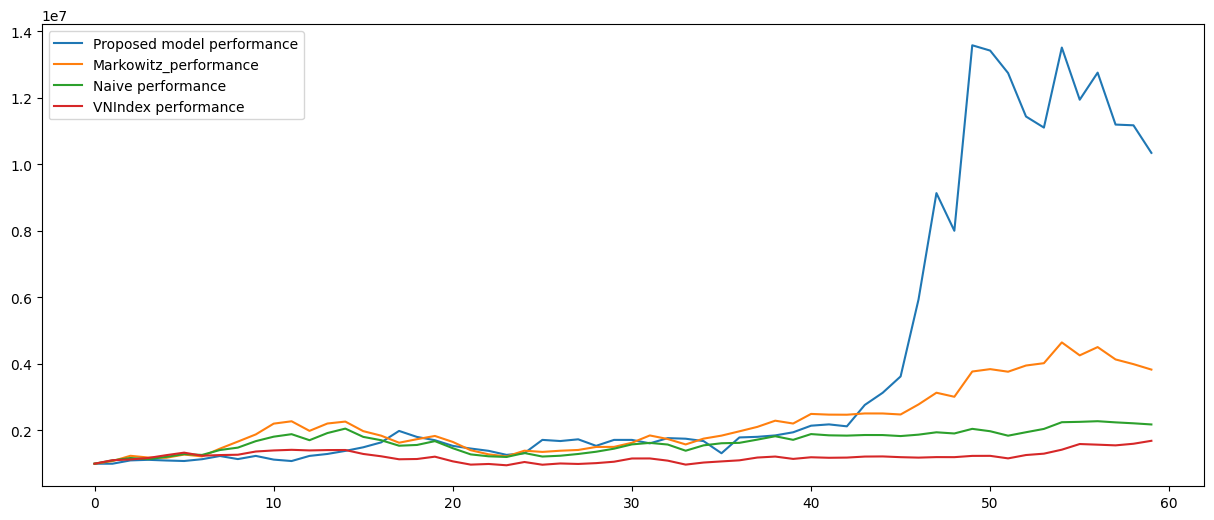

In [390]:
plt.figure(figsize=(15,6))
plt.plot(proposed_wealth,label='Proposed model performance')
plt.plot(markowitz_wealth,label = 'Markowitz_performance')
plt.plot(naive_wealth,label="Naive performance")
plt.plot(vni_wealth, label='VNIndex performance')
plt.legend()


<h3>7.4. Active management strategy<h3>

In [ ]:
def active_strategy_position (previous_weight: np.ndarray, current_weight: np.ndarray,current_mp: np.ndarray, transaction_fee_rate:float,cash_holding:float, stock_holding: float ):
    transaction_fee = np.abs(current_weight - previous_weight)*stock_holding*transaction_fee_rate
    budget = stock_holding + cash_holding - transaction_fee
    position = budget*current_weight/current_mp
    return position
def markowitz_input_function (current_date, number_of_month):
    

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
pd.date_range()

,ratio,g_log,omr,dpoc,lrr,wct,hskd,ht,wod
ticket,time,,,,,,,,
PNJ,2021-03-31,0.206646,0.093344,0.002616,3.959396,1.344873,0.883596,0.707080,0.466556
SAM,2021-03-31,-0.399163,0.075251,0.000000,0.000000,0.671891,0.075437,0.718288,0.274307
REE,2021-03-31,-0.300556,0.486721,0.132354,0.300016,0.638179,0.062292,0.606585,0.701323
QCG,2021-03-31,0.178174,0.103987,0.047235,15.956501,0.145586,0.034742,0.423745,0.083601
PVT,2021-03-31,-0.264383,0.144957,0.126525,0.473317,-17.558864,0.160344,0.567129,0.570655
...,...,...,...,...,...,...,...,...,...
FPT,2025-09-30,-0.002127,0.202119,0.051542,0.886838,-6.549769,0.215770,0.517663,0.490828
ELC,2025-09-30,0.442905,0.117937,0.011721,0.629130,0.511788,0.179292,0.603291,0.343384
DXG,2025-09-30,0.307152,0.229213,0.017562,0.682292,0.060746,0.031654,0.538267,0.389902
